![Fixel Algorithms](https://fixelalgorithms.co/images/CCExt.png)

# <center> Deep Learning Methods </center>
## <center> Lecture 4 - Deep Learning Basics</center>
### <center> Regularization Methods (Weight Decay and Dropout) </center>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FixelAlgorithmsTeam/FixelCourses/blob/master/DeepLearningMethods/04_Regularizations/MainRegularization.ipynb)

In [1]:
#-- Wide screen:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
#-- Auto reload:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib

np.random.seed(2)

For Colab users:

In [4]:
if 'google.colab' in str(get_ipython()):
    !npx degit FixelAlgorithmsTeam/FixelCourses/DeepLearningMethods/04_Regularizations/DeepLearningFramework ./DeepLearningFramework

In [5]:
#-- What we have so far:
from DeepLearningFramework.Layers    import LinearLayer, ReLULayer
from DeepLearningFramework.Models    import SequentialModel
from DeepLearningFramework.Metric    import CrossEntropyLoss, Accuracy
from DeepLearningFramework.Dataset   import Dataset
from DeepLearningFramework.Optimizer import Optimizer, SGDM
from DeepLearningFramework.Training  import Epoch

### Get Cifar-10 dataset

In [6]:
import torchvision
import torchvision.transforms as transforms

#-- For now, we use PyTorch just to get the data:
oTrainSet = torchvision.datasets.CIFAR10(root='../../data', train=True,  download=True, transform=transforms.ToTensor())
oTestSet  = torchvision.datasets.CIFAR10(root='../../data', train=False, download=True, transform=transforms.ToTensor())

mTrainX = oTrainSet.data.reshape((-1, 32*32*3)) / 255
mTestX  = oTestSet .data.reshape((-1, 32*32*3)) / 255
vTrainY = np.array(oTrainSet.targets)
vTestY  = np.array(oTestSet .targets)

(
mTrainX.shape,
vTrainY.shape,
mTestX .shape,
vTestY .shape,
)

Files already downloaded and verified
Files already downloaded and verified


((50000, 3072), (50000,), (10000, 3072), (10000,))

In [7]:
lClasses = oTrainSet.classes
list(zip(range(10), lClasses))

[(0, 'airplane'),
 (1, 'automobile'),
 (2, 'bird'),
 (3, 'cat'),
 (4, 'deer'),
 (5, 'dog'),
 (6, 'frog'),
 (7, 'horse'),
 (8, 'ship'),
 (9, 'truck')]

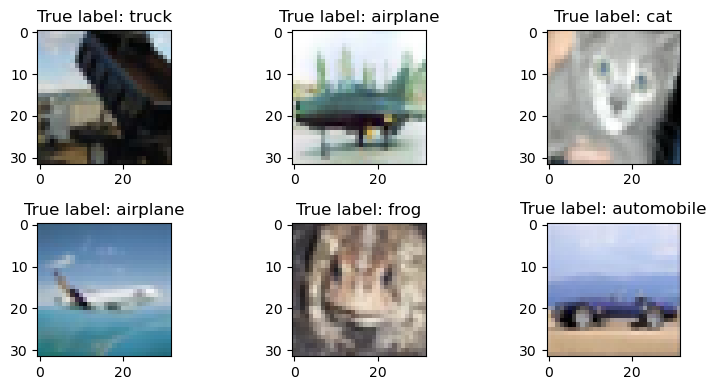

In [8]:
#-- Plot a few examples:
N, d   = mTrainX.shape
fig, _ = plt.subplots(2, 3, figsize=(8, 4))
for ax in fig.axes:
    idx = np.random.randint(N)
    ax.imshow   (np.reshape(mTrainX[idx,:], (32, 32, 3)))
    ax.set_title(f'True label: {lClasses[vTrainY[idx]]}')
    
plt.tight_layout()
plt.show()

####  Normalize data:

In [9]:
vMean = mTrainX.mean(0)
vStd  = mTrainX.std (0)

mTrainX -= vMean
mTestX  -= vMean
mTrainX /= vStd
mTestX  /= vStd

#### Data loaders:

In [10]:
batchSize = 256
oTrainSet = Dataset(mTrainX.T, vTrainY, 1*batchSize)
oTestSet  = Dataset(mTestX.T,  vTestY,  2*batchSize)

###  Define a model:

In [11]:
def GetModel():
    dIn = 32 * 32 * 3
    
    oModel = SequentialModel([
        LinearLayer(dIn, 200), ReLULayer(),
        LinearLayer(200, 100), ReLULayer(),
        LinearLayer(100, 50 ), ReLULayer(),
        LinearLayer(50,  10 ),
    ])
    
    return oModel

### Early stopping:
* We store the best model after each epoch.  
* Define best model either w.r.t the `loss` or w.r.t the `accuracy`.
* For now, we will use `pickle`; later, we will use `PyTorch`.

In [12]:
import time
import _pickle as pickle

def TrainModel(oModel, oTrainData, oValData, nEpochs, oOptim):

    vTrainLoss = np.full(nEpochs, np.nan)
    vTrainAcc  = np.full(nEpochs, np.nan)
    vValLoss   = np.full(nEpochs, np.nan)
    vValAcc    = np.full(nEpochs, np.nan)
    #===================================#
    bestAcc    = 0
    #===================================#
        
    for epoch in range(nEpochs):
        startTime           = time.time()
        trainLoss, trainAcc = Epoch(oModel, oTrainData, oOptim, bTrain=True )
        valLoss,   valAcc   = Epoch(oModel, oValData,           bTrain=False)
        epochTime           = time.time() - startTime

        #-- Display:
        print('Epoch '              f'{epoch    :03d}:',   end='')
        print(' | Train loss: '     f'{trainLoss:6.3f}',   end='')
        print(' | Val loss: '       f'{valLoss  :6.3f}',   end='')
        print(' | Train Accuracy: ' f'{trainAcc :6.3f}',   end='')
        print(' | Val Accuracy: '   f'{valAcc   :6.3f}',   end='')
        print(' | epoch time: '     f'{epochTime:6.3f} |', end='')

        vTrainLoss[epoch] = trainLoss
        vTrainAcc [epoch] = trainAcc
        vValLoss  [epoch] = valLoss
        vValAcc   [epoch] = valAcc
        
        #=============================================#
        #-- Save best model (early stopping):
        if valAcc > bestAcc:
            bestAcc = valAcc
            print(' <-- Checkpoint!', end='')
            with open('BestModel.pkl', 'wb') as oFile:
                pickle.dump(oModel, oFile)
        print('')
        #=============================================#
                
    #=============================================#
    #-- Load best model (early stopping):
    with open('BestModel.pkl', 'rb') as oFile:
        oModel = pickle.load(oFile)
    #=============================================#
                
    return oModel, (vTrainLoss, vTrainAcc, vValLoss, vValAcc)

### Train without weight decay:

In [13]:
oModel    = GetModel()
oOptim    = Optimizer(SGDM(lr=2e-2, β=0.9))
nEpochs   = 20

oModel, lHistory = TrainModel(oModel, oTrainSet, oTestSet, nEpochs, oOptim)

Epoch 000: | Train loss:  1.745 | Val loss:  1.555 | Train Accuracy:  0.384 | Val Accuracy:  0.444 | epoch time:  3.151 | <-- Checkpoint!
Epoch 001: | Train loss:  1.504 | Val loss:  1.495 | Train Accuracy:  0.467 | Val Accuracy:  0.476 | epoch time:  3.227 | <-- Checkpoint!
Epoch 002: | Train loss:  1.393 | Val loss:  1.453 | Train Accuracy:  0.506 | Val Accuracy:  0.488 | epoch time:  3.128 | <-- Checkpoint!
Epoch 003: | Train loss:  1.316 | Val loss:  1.435 | Train Accuracy:  0.533 | Val Accuracy:  0.500 | epoch time:  3.151 | <-- Checkpoint!
Epoch 004: | Train loss:  1.252 | Val loss:  1.422 | Train Accuracy:  0.555 | Val Accuracy:  0.509 | epoch time:  3.163 | <-- Checkpoint!
Epoch 005: | Train loss:  1.202 | Val loss:  1.412 | Train Accuracy:  0.573 | Val Accuracy:  0.499 | epoch time:  3.276 |
Epoch 006: | Train loss:  1.148 | Val loss:  1.408 | Train Accuracy:  0.592 | Val Accuracy:  0.509 | epoch time:  3.314 |
Epoch 007: | Train loss:  1.104 | Val loss:  1.424 | Train Accurac

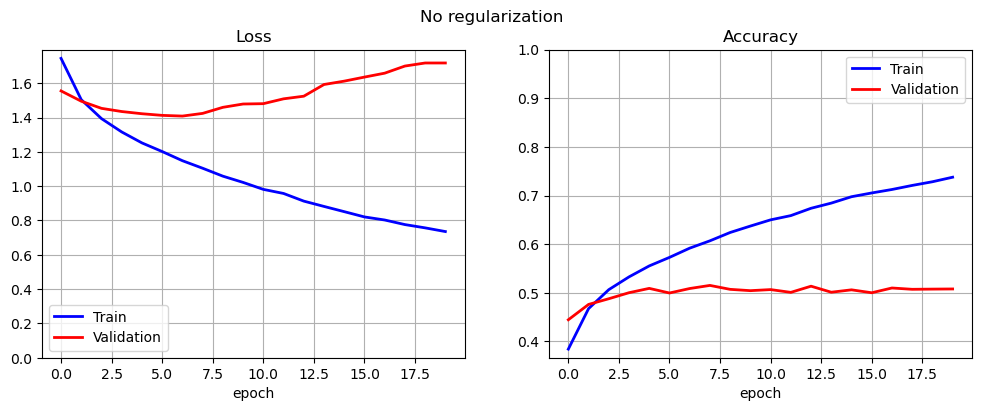

In [14]:
def PlotHistory(lHistory):

    vTrainLoss, vTrainAcc, vValLoss, vValAcc = lHistory
    
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1,2,1)
    plt.plot   (vTrainLoss, 'b', lw=2, label='Train'     )
    plt.plot   (vValLoss,   'r', lw=2, label='Validation')
    plt.title  ('Loss')
    plt.xlabel ('epoch')
    plt.ylim   (bottom=0)
    plt.legend ()
    plt.grid   ()

    plt.subplot(1,2,2)
    plt.plot   (vTrainAcc, 'b', lw=2, label='Train'     )
    plt.plot   (vValAcc,   'r', lw=2, label='Validation')
    plt.title  ('Accuracy')
    plt.xlabel ('epoch')
    plt.ylim   (top=1)
    plt.legend ()
    plt.grid   ()
    
PlotHistory (lHistory)
plt.suptitle('No regularization')
plt.show    ()

### SGDMW - SGDM with weight decay
1. $\boldsymbol{v}^{\left(t\right)}=\beta\boldsymbol{v}^{\left(t-1\right)}-\mu\nabla L\left(\boldsymbol{p}^{\left(t\right)}\right)$
2. $\boldsymbol{p}^{\left(t+1\right)}=\boldsymbol{p}^{\left(t\right)}+\boldsymbol{v}^{\left(t\right)}-\lambda\boldsymbol{p}^{\left(t\right)}$

In [15]:
class SGDMW:
    def __init__(self, lr=1e-3, β=0.9, wd=0):
        self.lr = lr
        self.β  = β
        self.wd = wd #-- weight decay

    def Step(self, mW, mDw, dState={}):
        mV            = dState.get('mV', np.zeros(mW.shape))
        mV            = self.β * mV - self.lr * mDw
        mW           += mV - self.wd * mW
        dState['mV']  = mV

        return mW, dState

#### Train with weight decay:

In [16]:
oModel  = GetModel()
oOptim  = Optimizer(SGDMW(lr=2e-2, β=0.9, wd=2e-3))
nEpochs = 20

oModel, lHistory = TrainModel(oModel, oTrainSet, oTestSet, nEpochs, oOptim)

Epoch 000: | Train loss:  1.734 | Val loss:  1.559 | Train Accuracy:  0.388 | Val Accuracy:  0.448 | epoch time:  3.688 | <-- Checkpoint!
Epoch 001: | Train loss:  1.506 | Val loss:  1.479 | Train Accuracy:  0.469 | Val Accuracy:  0.476 | epoch time:  3.703 | <-- Checkpoint!
Epoch 002: | Train loss:  1.435 | Val loss:  1.452 | Train Accuracy:  0.492 | Val Accuracy:  0.489 | epoch time:  3.779 | <-- Checkpoint!
Epoch 003: | Train loss:  1.402 | Val loss:  1.426 | Train Accuracy:  0.504 | Val Accuracy:  0.500 | epoch time:  3.882 | <-- Checkpoint!
Epoch 004: | Train loss:  1.367 | Val loss:  1.430 | Train Accuracy:  0.519 | Val Accuracy:  0.499 | epoch time:  3.750 |
Epoch 005: | Train loss:  1.346 | Val loss:  1.410 | Train Accuracy:  0.527 | Val Accuracy:  0.498 | epoch time:  3.746 |
Epoch 006: | Train loss:  1.336 | Val loss:  1.403 | Train Accuracy:  0.529 | Val Accuracy:  0.508 | epoch time:  3.709 | <-- Checkpoint!
Epoch 007: | Train loss:  1.321 | Val loss:  1.396 | Train Accurac

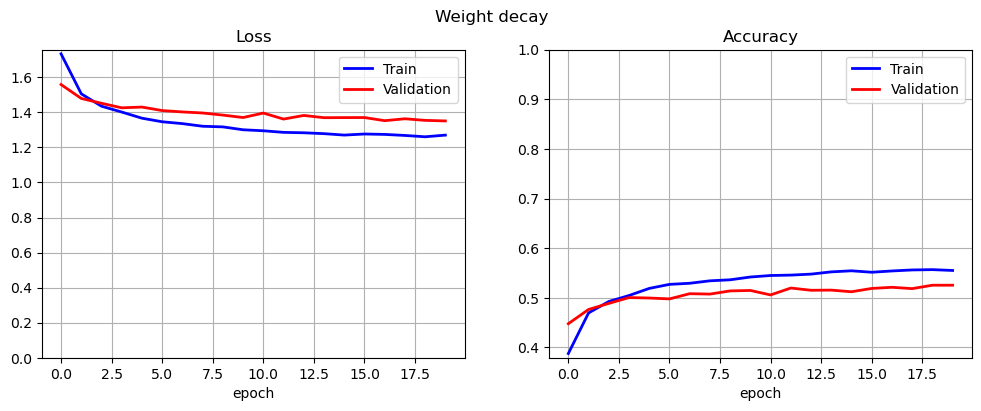

In [17]:
PlotHistory (lHistory)
plt.suptitle('Weight decay')
plt.show    ()

### Dropout layer:
Forwrad:
$$\boldsymbol{z}=\frac{1}{p}\boldsymbol{x}\odot\boldsymbol{m}=\frac{1}{p}\text{diag}\left(\boldsymbol{m}\right)\boldsymbol{x}$$
where $\boldsymbol{m}$ is a mask (same size as $\boldsymbol{x}$)
such that each $\boldsymbol{m}\left[i\right]\sim\text{Bernoulli}\left(p\right)$

Backward:
$$
\left\langle \nabla_{\boldsymbol{z}}L,\nabla_{\boldsymbol{x}}\boldsymbol{z}\left[\boldsymbol{h}\right]\right\rangle =\left\langle \nabla_{\boldsymbol{z}}L,\frac{1}{p}\text{diag}\left(\boldsymbol{m}\right)\boldsymbol{h}\right\rangle =\left\langle \frac{1}{p}\text{diag}\left(\boldsymbol{m}\right)\nabla_{\boldsymbol{z}}L,\boldsymbol{h}\right\rangle 
$$
$$
\implies\boxed{\nabla_{\boldsymbol{x}}L=\frac{1}{p}\text{diag}\left(\boldsymbol{m}\right)\nabla_{\boldsymbol{z}}L=\frac{1}{p}\nabla_{\boldsymbol{z}}L\odot\boldsymbol{m}}
$$
* `Forward` - for train time (with dropout).
* `Predict` - for test  time (without dropout).

In [18]:
class DropoutLayer:
    def __init__(self, p=0.5):
        self.dParams = {}
        self.dGrads  = {}
        self.p       = p

    #-- Train time:
    def Forward(self, mX):
        self.mMask = (np.random.rand(*mX.shape) < self.p) / self.p
        mZ         = mX * self.mMask

        return mZ

    #-- Test time:
    def Predict(self, mX):
        return mX
    
    def Backward(self, mDz):
        mDx   = mDz * self.mMask

        return mDx

###  Update `SequentialModel` class
* `self.train = True`  for train time.
* `self.train = False` for test time.
* `Forward` checks for `self.train`.

In [19]:
class SequentialModel:
    def __init__(self, lLayers):
        self.lLayers = lLayers
        #======================#
        self.train   = False
        #======================#

    def Forward(self, mX):
        for oLayer in self.lLayers:
            #====================================================#
            if self.train == False and hasattr(oLayer, 'Predict'):
                mX = oLayer.Predict(mX) #-- test time
            else:
                mX = oLayer.Forward(mX) #-- train time
            #====================================================#
        return mX

    def Backward(self, mDz):
        for oLayer in reversed(self.lLayers):
            mDz = oLayer.Backward(mDz)

#### Set `oModel.train` before `Epoch`:

In [20]:
import time
import _pickle as pickle

def TrainModel(oModel, oTrainData, oValData, nEpochs, oOptim):

    vTrainLoss = np.full(nEpochs, np.nan)
    vTrainAcc  = np.full(nEpochs, np.nan)
    vValLoss   = np.full(nEpochs, np.nan)
    vValAcc    = np.full(nEpochs, np.nan)
    bestAcc    = 0
        
    for epoch in range(nEpochs):
        startTime = time.time()
        #===================================================================#
        oModel.train        = True 
        trainLoss, trainAcc = Epoch(oModel, oTrainData, oOptim, bTrain=True )
        #===================================================================#
        #===================================================================#
        oModel.train        = False
        valLoss,   valAcc   = Epoch(oModel, oValData,           bTrain=False)
        #===================================================================#
        epochTime = time.time() - startTime

        #-- Display:
        print('Epoch '              f'{epoch    :03d}:',   end='')
        print(' | Train loss: '     f'{trainLoss:6.3f}',   end='')
        print(' | Val loss: '       f'{valLoss  :6.3f}',   end='')
        print(' | Train Accuracy: ' f'{trainAcc :6.3f}',   end='')
        print(' | Val Accuracy: '   f'{valAcc   :6.3f}',   end='')
        print(' | epoch time: '     f'{epochTime:6.3f} |', end='')

        vTrainLoss[epoch] = trainLoss
        vTrainAcc [epoch] = trainAcc
        vValLoss  [epoch] = valLoss
        vValAcc   [epoch] = valAcc
        
        #-- Save best model (early stopping):
        if valAcc > bestAcc:
            bestAcc = valAcc
            print(' <-- Checkpoint!', end='')
            with open('BestModel.pkl', 'wb') as oFile:
                pickle.dump(oModel, oFile)
        print('')
                
    #-- Load best model (early stopping):
    with open('BestModel.pkl', 'rb') as oFile:
        oModel = pickle.load(oFile)
                
    return oModel, (vTrainLoss, vTrainAcc, vValLoss, vValAcc)

### Model with dropouts:

In [21]:
def GetModelWithDropout(dropout=0.5):
    dIn = 32 * 32 * 3
    
    oModel = SequentialModel([
        LinearLayer(dIn, 200), ReLULayer(), DropoutLayer(dropout),
        LinearLayer(200, 100), ReLULayer(), DropoutLayer(dropout),
        LinearLayer(100, 50 ), ReLULayer(), DropoutLayer(dropout),
        LinearLayer(50,  10 ),
    ])
    
    return oModel

#### Train with dropout:

In [22]:
oModel  = GetModelWithDropout(0.9)
oOptim  = Optimizer(SGDM(lr=2e-2, β=0.9))
nEpochs = 20

oModel, lHistory = TrainModel(oModel, oTrainSet, oTestSet, nEpochs, oOptim)

Epoch 000: | Train loss:  1.886 | Val loss:  1.629 | Train Accuracy:  0.330 | Val Accuracy:  0.422 | epoch time:  3.361 | <-- Checkpoint!
Epoch 001: | Train loss:  1.648 | Val loss:  1.534 | Train Accuracy:  0.414 | Val Accuracy:  0.456 | epoch time:  3.320 | <-- Checkpoint!
Epoch 002: | Train loss:  1.565 | Val loss:  1.479 | Train Accuracy:  0.447 | Val Accuracy:  0.478 | epoch time:  3.402 | <-- Checkpoint!
Epoch 003: | Train loss:  1.506 | Val loss:  1.441 | Train Accuracy:  0.463 | Val Accuracy:  0.489 | epoch time:  3.374 | <-- Checkpoint!
Epoch 004: | Train loss:  1.458 | Val loss:  1.429 | Train Accuracy:  0.483 | Val Accuracy:  0.494 | epoch time:  3.362 | <-- Checkpoint!
Epoch 005: | Train loss:  1.419 | Val loss:  1.420 | Train Accuracy:  0.497 | Val Accuracy:  0.498 | epoch time:  3.446 | <-- Checkpoint!
Epoch 006: | Train loss:  1.390 | Val loss:  1.388 | Train Accuracy:  0.508 | Val Accuracy:  0.507 | epoch time:  3.357 | <-- Checkpoint!
Epoch 007: | Train loss:  1.355 | 

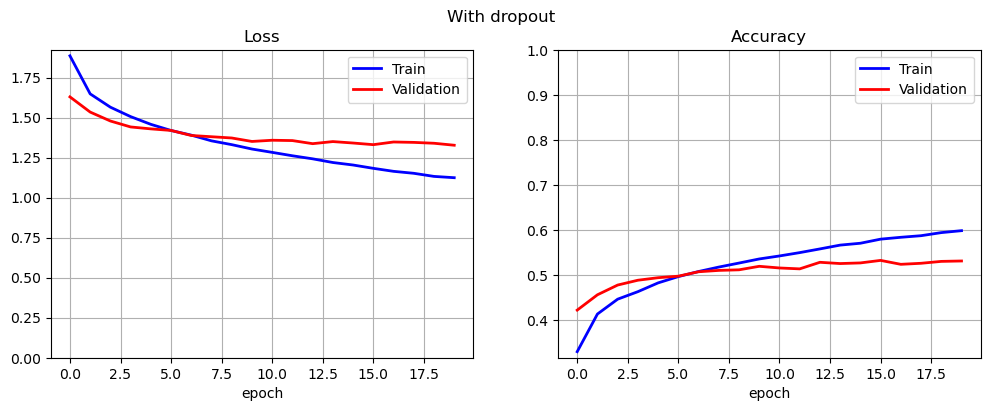

In [23]:
PlotHistory (lHistory)
plt.suptitle('With dropout')
plt.show    ()

### Dropout + weight decay:

In [24]:
oModel  = GetModelWithDropout(0.9)
oOptim  = Optimizer(SGDMW(lr=2e-2, β=0.9, wd=5e-4))
nEpochs = 20

oModel, lHistory = TrainModel(oModel, oTrainSet, oTestSet, nEpochs, oOptim)

Epoch 000: | Train loss:  1.875 | Val loss:  1.618 | Train Accuracy:  0.327 | Val Accuracy:  0.422 | epoch time:  3.899 | <-- Checkpoint!
Epoch 001: | Train loss:  1.641 | Val loss:  1.520 | Train Accuracy:  0.415 | Val Accuracy:  0.463 | epoch time:  3.814 | <-- Checkpoint!
Epoch 002: | Train loss:  1.549 | Val loss:  1.479 | Train Accuracy:  0.451 | Val Accuracy:  0.477 | epoch time:  3.971 | <-- Checkpoint!
Epoch 003: | Train loss:  1.491 | Val loss:  1.460 | Train Accuracy:  0.473 | Val Accuracy:  0.484 | epoch time:  3.992 | <-- Checkpoint!
Epoch 004: | Train loss:  1.437 | Val loss:  1.414 | Train Accuracy:  0.493 | Val Accuracy:  0.500 | epoch time:  3.883 | <-- Checkpoint!
Epoch 005: | Train loss:  1.398 | Val loss:  1.386 | Train Accuracy:  0.501 | Val Accuracy:  0.507 | epoch time:  4.055 | <-- Checkpoint!
Epoch 006: | Train loss:  1.362 | Val loss:  1.370 | Train Accuracy:  0.518 | Val Accuracy:  0.518 | epoch time:  3.828 | <-- Checkpoint!
Epoch 007: | Train loss:  1.340 | 

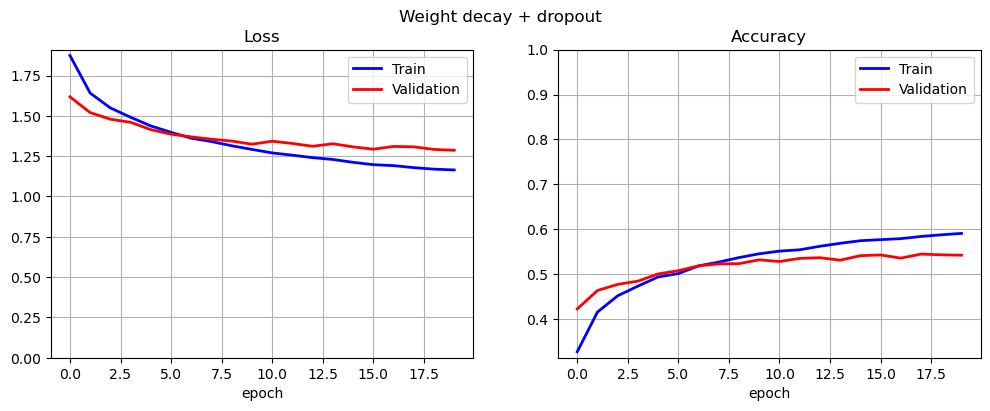

In [25]:
PlotHistory (lHistory)
plt.suptitle('Weight decay + dropout')
plt.show    ()